# CLASIFICADOR DE SENTIMIENTOS EN TWEETS
En este notebook vamos a tener en cuenta varios modelos o clasificadores para al final de este poder guardarlo y poder usarlo en el recomendador de peliculas.
Vamos a comparar los siguientes clasificadores:
### Modelos
Multinomial, Bernoulli, Logistic Regression y SVC

In [18]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import joblib

# Global Parameters
stop_words = set(stopwords.words('english'))

In [19]:
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding='latin-1')
    dataset.columns = cols
    return dataset

tweets = load_dataset('data.csv', ['target', 't_id', 'created_at', 'query', 'user', 'text'])
tweets

,target,t_id,created_at,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
9995,4,1559421292,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,SEOJordan,Joomla is pretty confusing. I'm not sure if I ...
9996,4,1559421406,Sun Apr 19 11:05:45 PDT 2009,NO_QUERY,Cara62442,"@weeemo Yays, I can't wait"
9997,4,1559421425,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,BigPayLess,@KatDancing76 No .. I could find out .. do you...
9998,4,1559421482,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,paulmccord,@formatted_dad She cannot name one because the...


In [20]:
tweets['target']=tweets['target'].replace(4,1)
tweets

,target,t_id,created_at,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
9995,1,1559421292,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,SEOJordan,Joomla is pretty confusing. I'm not sure if I ...
9996,1,1559421406,Sun Apr 19 11:05:45 PDT 2009,NO_QUERY,Cara62442,"@weeemo Yays, I can't wait"
9997,1,1559421425,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,BigPayLess,@KatDancing76 No .. I could find out .. do you...
9998,1,1559421482,Sun Apr 19 11:05:46 PDT 2009,NO_QUERY,paulmccord,@formatted_dad She cannot name one because the...


In [21]:
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

n_tweets = remove_unwanted_cols(tweets, ['t_id', 'created_at', 'query', 'user'])
n_tweets

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
9995,1,Joomla is pretty confusing. I'm not sure if I ...
9996,1,"@weeemo Yays, I can't wait"
9997,1,@KatDancing76 No .. I could find out .. do you...
9998,1,@formatted_dad She cannot name one because the...


### Limpieza del texto
Hacemos una limpia del texto del tweet. Se eliminan las URLs, todas las referencias, los hashtags, las puntuaciones, eliminar las stopwords y por ultimo usamos la técnica de Lematización.
<br/><br/>
La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente.
<br/><br/>
![title](lematizacion.png)

In [22]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(lemma_words)

tweets.text = tweets['text'].apply(preprocess_tweet_text)
tweets

,target,text
0,0,upset cant updat facebook text might cri resul...
1,0,I dive mani time ball manag save 50 the rest g...
2,0,whole bodi feel itchi like fire
3,0,behav im mad I cant see
4,0,whole crew
...,...,...
9995,1,joomla pretti confus Im sure I like it wordpress
9996,1,yay I cant wait
9997,1,No I could find know suggest song
9998,1,she name one realli left


### Usamos TFidf Vectorizer
TF-IDF (Frecuencia de documento de frecuencia de inversión de término) es una técnica de ponderación comúnmente utilizada en el procesamiento de información y la minería de datos. Esta técnica utiliza un método estadístico para calcular la importancia de una palabra en todo el corpus en función del número de veces que la palabra aparece en el texto y la frecuencia de los documentos que aparecen en todo el corpus. Su ventaja es que puede filtrar algunas palabras comunes pero irrelevantes, mientras retiene palabras importantes que afectan todo el texto.
<br/></br>
TF (Frecuencia de término) indica con qué frecuencia aparece una palabra clave en todo el artículo.
<br/>
IDF (Frecuencia de documento de inversión) significa calcular la frecuencia de texto invertida. La frecuencia del texto se refiere al número de veces que aparece una palabra clave en todos los artículos de todo el corpus. La frecuencia de documento invertida también se denomina frecuencia de documento inversa. Es el recíproco de la frecuencia de documento. Se utiliza principalmente para reducir el efecto de algunas palabras comunes en todos los documentos que tienen poco efecto en el documento.

In [23]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(tweets.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(tweets.iloc[:, 1]).ravel())
y = np.array(tweets.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# CLASIFICADORES
## MULTINOMIAL

In [24]:
# Training Multinomial Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
cross_cnb = cross_val_score(NB_model, X, y)
y_predict_nb = NB_model.predict(X_test)
print("Cross Validation score = ",cross_cnb)  
print(classification_report(y_test, y_predict_nb))       

Cross Validation score =  [0.7395 0.7455 0.73   0.7605 0.733 ]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       992
           1       0.77      0.68      0.72      1008

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



<AxesSubplot:>

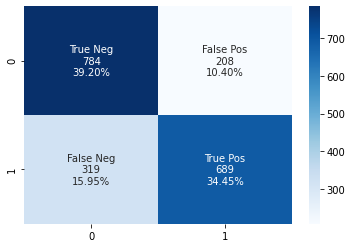

In [25]:
#This is the confusion matrix :
matrix = confusion_matrix(y_test,y_predict_nb)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

## BERNOULLI

In [26]:
# Training Bernoulli Naive Bayes model
BER_MODEL = BernoulliNB()
BER_MODEL.fit(X_train, y_train)
cross_ber = cross_val_score(BER_MODEL, X, y)
y_predict_ber = BER_MODEL.predict(X_test)
print("Cross Validation score = ",cross_cnb)  
print(classification_report(y_test, y_predict_ber))  

Cross Validation score =  [0.7395 0.7455 0.73   0.7605 0.733 ]
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       992
           1       0.74      0.73      0.74      1008

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



<AxesSubplot:>

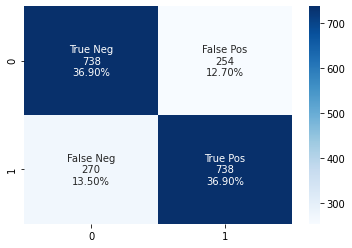

In [27]:
#This is the confusion matrix :
matrixB = confusion_matrix(y_test,y_predict_ber)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrixB.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrixB.flatten()/np.sum(matrixB)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrixB, annot=labels, fmt='', cmap='Blues')

## LOGISTIC REGRESSION MODEL

In [28]:
# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
cross_lr = cross_val_score(LR_model, X, y)
y_predict_lr = LR_model.predict(X_test)
print("Cross Validation score = ",cross_lr)  
print(classification_report(y_test, y_predict_lr))  

Cross Validation score =  [0.756  0.751  0.749  0.7485 0.7375]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       992
           1       0.76      0.74      0.75      1008

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



<AxesSubplot:>

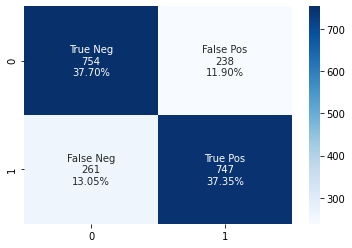

In [29]:
#This is the confusion matrix :
matrixC = confusion_matrix(y_test,y_predict_lr)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrixC.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrixC.flatten()/np.sum(matrixC)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrixC, annot=labels, fmt='', cmap='Blues')

## SVC MODEL

In [30]:
SVC_model = SVC(kernel = 'linear', random_state = 0, probability=True)
SVC_model.fit(X_train, y_train)
cross_svc = cross_val_score(SVC_model, X, y)
y_predict_svc = SVC_model.predict(X_test)
print("Cross Validation score = ",cross_svc)  
print(classification_report(y_test, y_predict_svc))  

Cross Validation score =  [0.7365 0.7505 0.744  0.7425 0.737 ]
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       992
           1       0.75      0.74      0.75      1008

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



<AxesSubplot:>

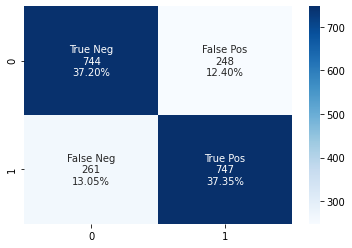

In [31]:
#This is the confusion matrix :
matrixD = confusion_matrix(y_test,y_predict_svc)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                matrixD.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrixD.flatten()/np.sum(matrixD)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrixD, annot=labels, fmt='', cmap='Blues')

## ROC CURVE TO COMPARE THE MODELS

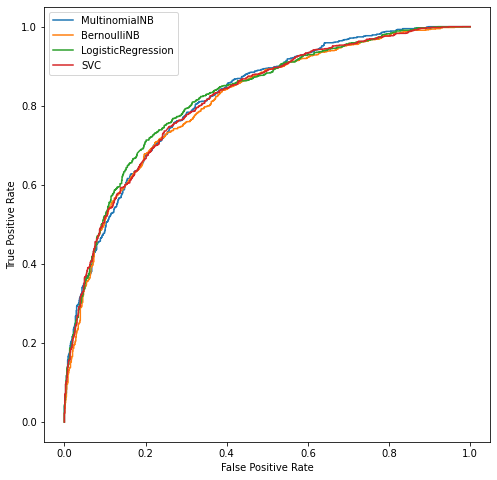

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
fpr_dt_1, tpr_dt_1,_=roc_curve(y_test,NB_model.predict_proba(X_test)[:,1])
fpr_dt_2, tpr_dt_2,_=roc_curve(y_test,BER_MODEL.predict_proba(X_test)[:,1])
fpr_dt_3, tpr_dt_3,_=roc_curve(y_test,LR_model.predict_proba(X_test)[:,1])
fpr_dt_4, tpr_dt_4,_=roc_curve(y_test,SVC_model.predict_proba(X_test)[:,1])
plt.plot(fpr_dt_1,tpr_dt_1,label="MultinomialNB")
plt.plot(fpr_dt_2,tpr_dt_2,label="BernoulliNB")
plt.plot(fpr_dt_3,tpr_dt_3,label="LogisticRegression")
plt.plot(fpr_dt_4,tpr_dt_4,label="SVC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(8, 8)
plt.show()

# Se guarda el modelo
Como el modelo Logistic Regression da una precisión un poquito mas elevada vamos a guardarlo y usarlo para el recomendador de peliculas

In [33]:
# save the model to disk
filename = 'lr_model.joblib'
joblib.dump(LR_model, filename)

['lr_model.joblib']

### Guardo el modelo de TFIdf

In [34]:
# save the model to disk
filename = 'tf_model.joblib'
joblib.dump(tf_vector, filename)

['tf_model.joblib']